In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%set_env PYTHONBREAKPOINT=IPython.core.debugger.set_trace

env: PYTHONBREAKPOINT=IPython.core.debugger.set_trace


In [2]:
from fastai.vision import *

In [3]:
vcand = np.load('vcand_case3.npy')
nview = 160

In [4]:
path = Path('./data_MIRO')
path.ls()

[PosixPath('data_MIRO/export_rN_expanded.pkl'),
 PosixPath('data_MIRO/val'),
 PosixPath('data_MIRO/cups'),
 PosixPath('data_MIRO/train'),
 PosixPath('data_MIRO/.ipynb_checkpoints'),
 PosixPath('data_MIRO/newCaptures.zip'),
 PosixPath('data_MIRO/models')]

In [5]:
classes = sorted(os.listdir(path/'train'))
classes

['bus',
 'car',
 'chair',
 'cleanser',
 'clock',
 'cup',
 'headphones',
 'mouse',
 'scissors',
 'shoe',
 'stapler',
 'sunglasses',
 'tape_cutter']

In [6]:
# For the validation dataset, count the number of data points for each class.
# Used to calculate accuracy-per-class during validation.

def directory(path,extension):
    list_dir = []
    list_dir = os.listdir(path)
    count = 0
    for file in list_dir:
        if file.endswith(extension): # eg: '.txt'
            count += 1
    return count

folders = [f.path for f in os.scandir(path/'val') if f.is_dir()]
folders = sorted(folders)
validCount = []
for folds in folders:
    validCount = np.append(validCount, directory(folds, '.png')//nview)
validCount = validCount.astype(int)

In [7]:
tfms = get_transforms(do_flip=False, flip_vert=False, max_rotate=0.0,
                  max_lighting=0.6, max_zoom=1.5, max_warp=0.0)

In [8]:
src = (ImageList.from_folder(path)
      .split_by_folder(train='train', valid='val')
      .label_from_folder())
src

LabelLists;

Train: LabelList (18720 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bus,bus,bus,bus,bus
Path: data_MIRO;

Valid: LabelList (2080 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bus,bus,bus,bus,bus
Path: data_MIRO;

Test: None

In [9]:
data = (src.transform(tfms, size=128)
        .databunch(bs=320).normalize(imagenet_stats))

data.train_dl = data.train_dl.new(shuffle=False)
data.valid_dl = data.valid_dl.new(shuffle=False)

if data.train_dl.dl.batch_size % nview != 0:
    print ('Error: batch size must be a multiplication of the number of views,', nview)
    exit()
    
sorted_img = sorted(data.train_ds.x.items)
sorted_cats = sorted(data.train_ds.y.items)

In [10]:
data.valid_ds.x.items[320]

PosixPath('data_MIRO/val/car/car_1_088.png')

In [11]:
# Random permutation for validation set. Probably not necessary, but just an experiment to see if it makes
# any difference during training/validation.

# sorted_vimg = sorted(data.valid_ds.x.items)
# sorted_vcats = sorted(data.valid_ds.y.items)

# val_nsamp = int( len(data.valid_ds) / nview )

# inds = np.zeros( ( nview, val_nsamp ) ).astype('int')
# inds[ 0 ] = np.random.permutation(range(val_nsamp)) * nview
# for i in range(1,nview):
#     inds[ i ] = inds[ 0 ] + i
# inds = inds.T.reshape( nview * val_nsamp )
# print(inds)

# IL  = ImageList([sorted_vimg[i] for i in inds], path=path)
# data.valid_ds.x = IL
# CL = CategoryList([sorted_vcats[i] for i in inds], classes=classes, path=path)
# data.valid_ds.y = CL

# Sort validation data for easier evaluation later
data.valid_ds.x = ImageList(sorted(data.valid_ds.x.items), path=path)
data.valid_ds.y = CategoryList(sorted(data.valid_ds.y.items), classes=classes, path=path)

In [12]:
# idx = random.randint(0, 50000)
# print(data.valid_ds[idx][1], idx)
# data.valid_ds.items[idx]

In [13]:
# idx = 8779
# print(data.train_ds[idx])
# data.train_ds[idx][0]

In [14]:
class GenerateTargetrN(LearnerCallback):

    "Creates the target labels for a rotationNet implementation."
    
    def __init__(self, learn:Learner):
        super().__init__(learn)
        self.target_var = torch.LongTensor( learn.data.train_dl.dl.batch_size * nview )
        self.output = torch.Tensor()
        
    def on_epoch_begin(self, **kwargs):
        self.viewOrd = {}
    
    def on_loss_begin(self, last_output, last_target, train, **kwargs:Any)->None:
        
        nsamp = int( last_output.size(0) / nview )
        target_ = torch.LongTensor( last_target.size(0) * nview )

        self.output = last_output
        num_classes = int( self.output.size( 1 ) / nview ) - 1
        self.output = self.output.view( -1, num_classes + 1 )

        # compute scores and decide target labels
        output_ = torch.nn.functional.log_softmax( self.output, dim=1 ) #try sigmoid instead?

        #subtracts the last col from every other col, removes last col
        output_ = output_[ :, :-1 ] - torch.t( output_[ :, -1 ].repeat(1, output_.size(1)-1).view(output_.size(1)-1, -1) )
        output_ = output_.view( -1, nview * nview, num_classes )
        output_ = output_.data.cpu().numpy()

        '''Arrange output_as:
           [x,:,:] = all the view's activations for image[x//num views]
           [:,y,:] = view activations for class[y]
           [:,:,z] = sample set[z]'''
        output_ = output_.transpose( 1, 2, 0 )

        #default view variable is the incorrect view
        for j in range(target_.size(0)):
            target_[ j ] = num_classes

        # Initialize scores to 0
        scores = np.zeros( ( vcand.shape[ 0 ], num_classes, nsamp ) )

        #add up scores for each of the candidates for viewpoint variables
        for j in range(vcand.shape[0]):
            for k in range(vcand.shape[1]):
                scores[ j ] = scores[ j ] + output_[ vcand[ j ][ k ] * nview + k ]

        for n in range( nsamp ):
            #finds max score for column that corresponds to target label (for each class label and sample group)
            j_max = np.argmax( scores[ :, last_target[ n * nview ], n ] )
            
            if train:
                if last_target[n*nview].item() in self.viewOrd:
                    self.viewOrd[last_target[n*nview].item()] = np.append(self.viewOrd[last_target[n*nview].item()], [j_max])

    #                 if self.viewOrd[last_target[n*nview].item()] != j_max:
    #                     self.viewOrd[last_target[n*nview].item()] = j_max
                else:
                    self.viewOrd.update( { last_target[n*nview].item() : [j_max] } )
                
            # Assign target labels. Only 1 view per image gets set to class label.
            # Others remain default, which is the incorrect view
            for k in range(vcand.shape[1]):
                target_[ n * nview * nview + vcand[ j_max ][ k ] * nview + k ] = last_target[ n * nview ]

        target_ = target_.cuda()
        self.target_var = torch.autograd.Variable(target_)
        
        if not train:
            return {'last_output':self.output, 'last_target':self.target_var}
                    
        f = open("viewOrderDict.pkl","wb")
        pickle.dump(self.viewOrd,f)
        f.close()

        return {'last_output':self.output, 'last_target':self.target_var}

In [15]:
class rNAccuracy(LearnerCallback):
    _order=-20
    
    "Metrics for rotationNet implementation."
    

    def __init__(self, learn):
        super().__init__(learn)
  
    def on_train_begin(self, **kwargs):
        self.learn.recorder.add_metric_names(['rN_t_loss','rN_v_loss','Prec@1',
                                              'Prec@2','class_acc','pose_acc','pose_prec'])
        self.vcount_tot = 0
        self.prec1, self.prec5 = 0., 0.
        
    def on_epoch_begin(self, **kwargs):
        self.tloss_tot, self.vloss_tot, self.tcount, self.vcount= 0., 0., 0, 0
        self.incTargs = []
        self.correctClassPct, self.correctPosePct, self.closePosePct = 0., 0., 0.
        self.chairCorrectCount = 0
        self.correctPoses = {}
        
        # Print weights to confirm body is frozen or not
#         print(list(learn.model.parameters())[0][0][0][1])
        
        # random permutation
        train_nsamp = int( len(learn.data.train_ds) / nview )
        
        inds = np.zeros( ( nview, train_nsamp ) ).astype('int')
        inds[ 0 ] = np.random.permutation(range(train_nsamp)) * nview
        for i in range(1,nview):
            inds[ i ] = inds[ 0 ] + i
        inds = inds.T.reshape( nview * train_nsamp )
        
        IL  = ImageList([sorted_img[i] for i in inds], path=path)
        learn.data.train_ds.x = IL
        CL = CategoryList([sorted_cats[i] for i in inds], classes=classes, path=path)
        learn.data.train_ds.y = CL
        
        #Print a random data item to check if they got shuffled correctly
#         idx = random.randint(0,len(learn.data.train_ds))
#         print(data.train_ds[idx][1], data.train_ds.items[idx])


    def on_batch_end(self, last_loss, last_output, last_target, train, **kwargs):
        
        if train:
            self.tloss_tot += last_loss
            self.tcount += 1
        else:
            self.vloss_tot += last_loss
            self.vcount += 1
            
            # Calculate accuracy
            output_ = last_output
            target = last_target
            target = target.cuda()
            target = target[target != 13]
            target = target[0:-1:nview]
            batch_size = target.size(0)
            num_classes = output_.size(1) - 1
#             num_classes = int(output_.size( 1 )/ nview) - 1

            output_ = output_.view( -1, num_classes + 1 )
            output_ = torch.nn.functional.log_softmax( output_, dim=1 )
            output_ = output_[ :, :-1 ] - torch.t( output_[ :, -1 ].repeat(1, output_.size(1)-1).view(output_.size(1)-1, -1) )
            output_ = output_.view( -1, nview * nview, num_classes )
            predOut = output_
            output_ = output_.data.cpu().numpy()
            output_ = output_.transpose( 1, 2, 0 )
            
            scores = np.zeros( ( vcand.shape[ 0 ], num_classes, batch_size ) )
            output = torch.zeros( ( batch_size, num_classes ) )

    
            for j in range(vcand.shape[0]):
                for k in range(vcand.shape[1]):
                    scores[ j ] = scores[ j ] + output_[ vcand[ j ][ k ] * nview + k ]

            for n in range( batch_size ):
                # For a given batch, n, np.argmax( scores[ :, :, n ] ) / scores.shape[ 1 ]
                # gets the index for the view that has the highest score, regardless of class.
                j_max = int( np.argmax( scores[ :, :, n ] ) / scores.shape[ 1 ] )
                # Scores[ j_max, :, n ] -- for batch n, view with highest score regardless of class.
                output[ n ] = torch.FloatTensor( scores[ j_max, :, n ] )

            # output[x,:] - view that had the highest class score for sample[x]
            # output[:,y] - score for class[y]
            output = output.cuda()


            topk = (1,2)
            maxk = max(topk)
            _, pred = output.topk(maxk, 1, True, True)
            pred = pred.t()

            correct = pred.eq(target.contiguous().view(1, -1).expand_as(pred))

            prec = []
            for k in topk:
                correct_k = correct[:k].view(-1).float().sum(0)
                prec.append(correct_k.mul_(100.0 / batch_size))
                
            self.prec1 += prec[0]*(last_output.size(0)//nview)
            self.prec5 += prec[1]*(last_output.size(0)//nview)
            self.vcount_tot += (last_output.size(0)//nview)
            
            # Save off incorrect predictions for evaluation at epoch end.
            idx =  (correct[0] == 0).nonzero()
            self.incTargs = np.append(self.incTargs, target[idx.view(-1)].data.cpu().numpy())
            
            # Evaluate predictions for metrics
            viewOrd = pickle.load(open("viewOrderDict.pkl", "rb"))
            for key, val in viewOrd.items():
                values, counts = np.unique(val, return_counts=True)
                viewOrd[key] = values[np.argmax(counts)]
            
            predictions = []
            posePreds = []
            correctClassCount = 0
            correctPoseCount = 0
            closePoseCount = 0
            for n in range(batch_size):
                for i in range(nview):
                    maxVals, idxs = torch.max(predOut[n][i*nview:i*nview+nview], dim=1)
                    predictions.append(idxs[torch.argmax(maxVals)].item())
                    posePreds.append(torch.argmax(maxVals).item())
#                     print(predictions, posePreds)
                    if predictions[-1] == target[n].item():
                        correctClassCount += 1
#                         if target[n].item() == 0 and vcand[viewOrd[predictions[i]]][posePreds[i]] == i:
#                             self.chairCorrectCount += 1
#                             print('Class prediction/actual:', idxs[torch.argmax(maxVals)].item(), target[n].item())
#                             print('-- Pose estimate/actual:', vcand[viewOrd[predictions[i]]][posePreds[i]], i)
                    image = vcand[viewOrd[predictions[-1]]][posePreds[-1]]
                    if image == i:
                        correctPoseCount += 1
                        if target[n].item() in self.correctPoses:
                            self.correctPoses[target[n].item()] = np.append(self.correctPoses[target[n].item()], [i])
                        else:
                            self.correctPoses.update( { target[n].item() : [i] } )
                            
                    poseArr = np.array([i-1, i+1, i-15, i-16, i-17, i+15, i+16, i+17])
                    if image in poseArr:
                        closePoseCount += 1
                        

            
#             print('Correct class pct:', correctClassCount/(nview*batch_size))
#             print('Correct pose pct:', correctPoseCount/(nview*batch_size))
            self.correctClassPct += (correctClassCount/(nview*batch_size))
            self.correctPosePct += (correctPoseCount/(nview*batch_size))
            self.closePosePct += ((closePoseCount+correctPoseCount)/(nview*batch_size))

            return {'last_output':output}


    def on_epoch_end(self, last_metrics, epoch, **kwargs):
        
#         print('\n*******EPOCH', epoch, '********\n')
#         print('Error rate by class:')
#         # Count classes that have been incorrectly classified
#         u, counts = np.unique(self.incTargs, return_counts=True)
#         v = [validCount[i] for i in u.astype(int)]
#         unique = [classes[i] for i in u.astype(int)]
#         corrects = ((counts/v * 100) + 0.5).astype(int) / 100.0
#         countDict = dict(zip(unique, corrects))
#         print(countDict, len(countDict))
        

#         print('vcount:', self.vcount)
#         print('\nEpoch', epoch, 'correct class accuracy:', self.correctClassPct/self.vcount)
#         print('Epoch', epoch, 'correct pose accuracy:', self.correctPosePct/self.vcount)

#         for key, value in self.correctPoses.items():
#             print(key, len(self.correctPoses[key]))
        
#         print('Number of correct bus pose estimates:',self.chairCorrectCount)
#         print('\n')

        return add_metrics(last_metrics, [self.tloss_tot/self.tcount, self.vloss_tot/self.vcount,
                                          self.prec1/self.vcount_tot, self.prec5/self.vcount_tot,
                                          self.correctClassPct/self.vcount, self.correctPosePct/self.vcount,
                                          self.closePosePct/self.vcount])

In [16]:
numClasses = (data.c+1)*nview
rotationNetHead = create_head(1024, numClasses)

In [17]:
learn = cnn_learner(data, models.resnet18, metrics=None, pretrained=True,
                    custom_head = rotationNetHead, callback_fns=[GenerateTargetrN, rNAccuracy])

In [27]:
learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,rN_t_loss,rN_v_loss,Prec@1,Prec@2,class_acc,pose_acc,pose_prec,time
0,2.893894,2.190508,2.965955,2.195014,38.461540,53.846153,0.078571,0.008036,0.053125,00:35
1,1.118783,0.058467,0.811474,0.058503,23.076923,38.461540,0.132143,0.007589,0.065625,00:35
2,0.368909,0.057047,0.064804,0.057107,20.512821,30.769232,0.103571,0.008929,0.070089,00:35
3,0.153430,0.052322,0.059785,0.052432,23.076923,32.692307,0.134821,0.012500,0.093750,00:35
4,0.086972,0.050859,0.057497,0.050814,27.692308,36.923077,0.096875,0.017411,0.093750,00:35
5,0.063858,0.045534,0.053838,0.045357,37.179489,46.153847,0.283036,0.049107,0.139286,00:34
6,0.051824,0.039421,0.046743,0.039196,45.054947,52.747253,0.378571,0.116071,0.285268,00:35
7,0.043721,0.033520,0.040530,0.032972,51.923077,58.653847,0.584821,0.207143,0.408036,00:35
8,0.037614,0.031012,0.035297,0.030538,56.410255,63.247864,0.623214,0.259821,0.467411,00:35
9,0.033949,0.028681,0.032104,0.028428,60.769230,66.923080,0.709821,0.296875,0.540625,00:35


In [28]:
learn.save('stage_1_MIRO')

In [18]:
learn.load('stage_1_MIRO');

In [29]:
learn.unfreeze()

In [30]:
learn.fit_one_cycle(45, slice(1e-6, 1e-2))

epoch,train_loss,valid_loss,rN_t_loss,rN_v_loss,Prec@1,Prec@2,class_acc,pose_acc,pose_prec,time
0,0.018509,0.018396,0.018559,0.017785,100.000000,100.000000,0.901339,0.554464,0.784821,00:40
1,0.018263,0.019137,0.018137,0.018465,100.000000,100.000000,0.904018,0.562500,0.790179,00:40
2,0.017955,0.017930,0.017754,0.017339,100.000000,100.000000,0.908036,0.565625,0.798214,00:40
3,0.017730,0.017933,0.017726,0.017326,100.000000,100.000000,0.905357,0.565179,0.798661,00:39
4,0.018134,0.017774,0.018018,0.017184,100.000000,100.000000,0.897321,0.576339,0.796429,00:39
5,0.017964,0.018989,0.017775,0.018236,100.000000,100.000000,0.891071,0.566071,0.790625,00:39
6,0.017859,0.017930,0.017769,0.017242,100.000008,100.000008,0.900000,0.581696,0.807143,00:39
7,0.017589,0.019218,0.017555,0.018436,100.000000,100.000000,0.869643,0.558929,0.779018,00:39
8,0.017941,0.018697,0.017926,0.018000,100.000000,100.000000,0.909375,0.569643,0.799107,00:40
9,0.017776,0.017453,0.017515,0.016960,100.000000,100.000000,0.904464,0.573661,0.805804,00:40


In [31]:
learn.save('stage_2_MIRO')

## Increase image size and retrain

In [18]:
learn.load('stage_2_MIRO');

In [19]:
data = (src.transform(tfms, size=224)
        .databunch(bs=320).normalize(imagenet_stats))

data.train_dl = data.train_dl.new(shuffle=False)
data.valid_dl = data.valid_dl.new(shuffle=False)

if data.train_dl.dl.batch_size % nview != 0:
    print ('Error: batch size must be a multiplication of the number of views,', nview)
    exit()
    
sorted_img = sorted(data.train_ds.x.items)
sorted_cats = sorted(data.train_ds.y.items)
data.valid_ds.x = ImageList(sorted(data.valid_ds.x.items), path=path)
data.valid_ds.y = CategoryList(sorted(data.valid_ds.y.items), classes=classes, path=path)

In [20]:
learn.data = data
learn.freeze()

In [21]:
learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,rN_t_loss,rN_v_loss,Prec@1,Prec@2,class_acc,pose_acc,pose_prec,time
0,0.012775,0.016063,0.013300,0.015472,100.000000,100.000000,0.935714,0.706696,0.872321,01:18
1,0.010909,0.016074,0.010488,0.015437,100.000000,100.000000,0.934821,0.707143,0.878571,01:14
2,0.010061,0.019013,0.009592,0.018197,100.000000,100.000000,0.924107,0.637500,0.852232,01:14
3,0.010255,0.022802,0.010086,0.021773,100.000000,100.000000,0.921429,0.635714,0.841518,01:14
4,0.010758,0.043011,0.010725,0.041527,100.000000,100.000000,0.643750,0.341964,0.556250,01:14
5,0.010780,0.021137,0.010831,0.020489,100.000000,100.000000,0.910714,0.641071,0.834375,01:15
6,0.010441,0.023199,0.010298,0.022792,100.000008,100.000008,0.880804,0.557589,0.773214,01:15
7,0.010438,0.021314,0.010363,0.020382,100.000000,100.000000,0.900000,0.605804,0.828125,01:15
8,0.010356,0.020646,0.010343,0.019686,100.000000,100.000000,0.914732,0.623661,0.848661,01:15
9,0.009579,0.027382,0.009261,0.026362,100.000000,100.000000,0.836607,0.521875,0.735268,01:14


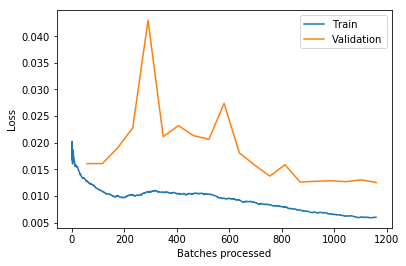

In [23]:
learn.recorder.plot_losses()

In [22]:
learn.save('stage_1_MIRO_L')

## Retrain entire unfrozen network

In [18]:
learn.load('stage_1_MIRO_L');

In [25]:
learn.unfreeze()

In [26]:
learn.fit_one_cycle(10, slice(1e-6, 1e-2))

epoch,train_loss,valid_loss,rN_t_loss,rN_v_loss,Prec@1,Prec@2,class_acc,pose_acc,pose_prec,time
0,0.005859,0.014162,0.005907,0.014162,100.000000,100.000000,0.948558,0.744712,0.900481,01:26
1,0.007366,0.017663,0.006987,0.017663,100.000000,100.000000,0.936058,0.691827,0.867308,01:26
2,0.009723,0.024660,0.009416,0.024660,100.000000,100.000000,0.887019,0.635096,0.830769,01:27
3,0.008795,0.020476,0.008930,0.020476,100.000000,100.000000,0.908173,0.651442,0.850481,01:27
4,0.008629,0.017709,0.008414,0.017709,100.000000,100.000000,0.914904,0.669231,0.856250,01:28
5,0.006988,0.016789,0.006993,0.016789,100.000000,100.000000,0.924519,0.707692,0.869231,01:28
6,0.005743,0.015975,0.005792,0.015975,100.000008,100.000008,0.938462,0.720192,0.888462,01:27
7,0.004896,0.016734,0.004819,0.016734,100.000000,100.000000,0.939904,0.720192,0.885096,01:27
8,0.004403,0.016981,0.004247,0.016981,100.000000,100.000000,0.937981,0.725962,0.888942,01:27
9,0.003938,0.017121,0.003970,0.017121,100.000000,100.000000,0.939904,0.732692,0.891346,01:27


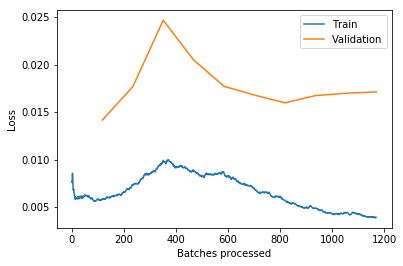

In [28]:
learn.recorder.plot_losses()

In [27]:
learn.save('stage_2_MIRO_L')

## Predict class and pose

In [ ]:
learn.load('stage_2_MIRO_L');

In [19]:
# Load saved pickle file of the "best view order" determined during training.

viewOrd = pickle.load(open("viewOrderDict.pkl", "rb"))
viewOrd

{9: array([15, 15, 15, 15, 15, 15, 15, 15, 15]),
 12: array([15, 15, 15, 15, 15, 15, 15, 15, 15]),
 1: array([15, 15, 15, 15, 15, 15, 15, 15, 15]),
 5: array([7, 7, 7, 7, 7, 7, 7, 7, 7]),
 7: array([15, 15, 15, 15, 15, 15, 15, 15, 15]),
 2: array([3, 3, 3, 3, 3, 3, 3, 3, 3]),
 3: array([0, 0, 0, 0, 0, 0, 0, 0, 0]),
 0: array([15, 15, 15, 15, 15, 15, 15, 15, 15]),
 10: array([15, 15, 15, 15, 15, 15, 15, 15, 15]),
 6: array([15, 15, 15, 15, 15, 15, 15, 15, 15]),
 4: array([ 0,  0, 12,  0, 12, 12,  4, 12, 12]),
 8: array([2, 2, 2, 2, 2, 2, 2, 2, 2]),
 11: array([7, 7, 7, 7, 7, 7, 7, 7, 7])}

In [20]:
for key, val in viewOrd.items():
    values, counts = np.unique(val, return_counts=True)
    viewOrd[key] = values[np.argmax(counts)]
viewOrd

{9: 15,
 12: 15,
 1: 15,
 5: 7,
 7: 15,
 2: 3,
 3: 0,
 0: 15,
 10: 15,
 6: 15,
 4: 12,
 8: 2,
 11: 7}

In [42]:
# Load one image for prediction

# img = open_image('data/shoe2.jpg')
# batch = learn.data.one_item(img)
# xb, yb = batch
# xb = [xb]
# img

NameError: name 'i' is not defined

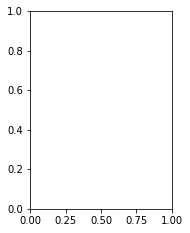

In [43]:
# Grab whatever images are in the path

path = Path('./data_MIRO/cups')
xb = torch.cuda.FloatTensor()
fig=plt.figure(figsize=(30, 8))
columns = 10 #columns = min(randnum, 10)
rows = 2
j = 1
sampleRange = range(0,10)
samp = iter(sampleRange)

for fname in os.listdir(path):
    # print('Data detected. Evaluating...', fname)
    img = open_image(path/fname)
    # print('Adding data...', fname)
    batch = learn.data.one_item(img)
    b,_ = batch
    xb = torch.cat((xb, b), dim=0)
    
    if j<=10:
        img = PIL.Image.open(path/fname)
        fig.add_subplot(rows, columns, j)
        plt.xlabel('Input image '+str(i+1), fontsize=16)
        plt.tick_params(axis='both', left=False, bottom=False, labelbottom=False, labelleft=False)
        fig.suptitle('Predicting Class and Pose', fontsize=25)
        j += 1
        plt.imshow(img)
        
xb = [xb]
learn.model.eval()
out = learn.model(*xb)
batch_size = xb[0].size(0)
num_classes = int(out.size( 1 )/ nview) - 1
out = out.view( -1, num_classes + 1 )
out = torch.nn.functional.log_softmax( out, dim=1 )
out = out[ :, :-1 ] - torch.t( out[ :, -1 ].repeat(1, out.size(1)-1).view(out.size(1)-1, -1) )
predictions = []
posePreds = []
for i in range(batch_size): 
    maxVals, idxs = torch.max(out[i*nview:i*nview+nview], dim=1)
    predictions.append(idxs[torch.argmax(maxVals)].item())
    posePreds.append(torch.argmax(maxVals).item())
#     print('prediction:', classes[idxs[torch.argmax(maxVals)].item()], '-- pose:', torch.argmax(maxVals).item())
values, counts = np.unique(predictions, return_counts=True)


j = columns+1

for i in range(10):
    pose = vcand[viewOrd[predictions[i]]][posePreds[i]]
    img = PIL.Image.open(sorted_img[predictions[i]*nview*9+nview*2+pose])
    start = sampleRange[0]+i
    poseArr = np.array([start-1, start+1, start-15, start-16, start-17, start+15, start+16, start+17])
    if pose == start:
        cPose = 'Correct'
    elif pose in poseArr:
        cPose = 'Close'
    else:
        cPose = 'Incorrect'
    fig.add_subplot(rows, columns, j)
#     plt.ylabel('Predicted pose:'+str(posePreds[i]), fontsize=16)
    plt.xlabel('Predicted class:'+classes[predictions[i]]+'\nPredicted pose:'+str(pose)+'\nPose: '+cPose, fontsize=14)
    plt.tick_params(axis='both', left=False, bottom=False, labelbottom=False, labelleft=False)
    j += 1
    plt.imshow(img)
    if i == batch_size-1:
        break

plt.show()
# plt.tight_layout()

print('*'*60)
print('PREDICTED CLASS:', classes[values[np.argmax(counts)]], '-- predicted from', batch_size, 'views')
if batch_size > 10:
    print('Showing first 10 views only')
print('*'*60)

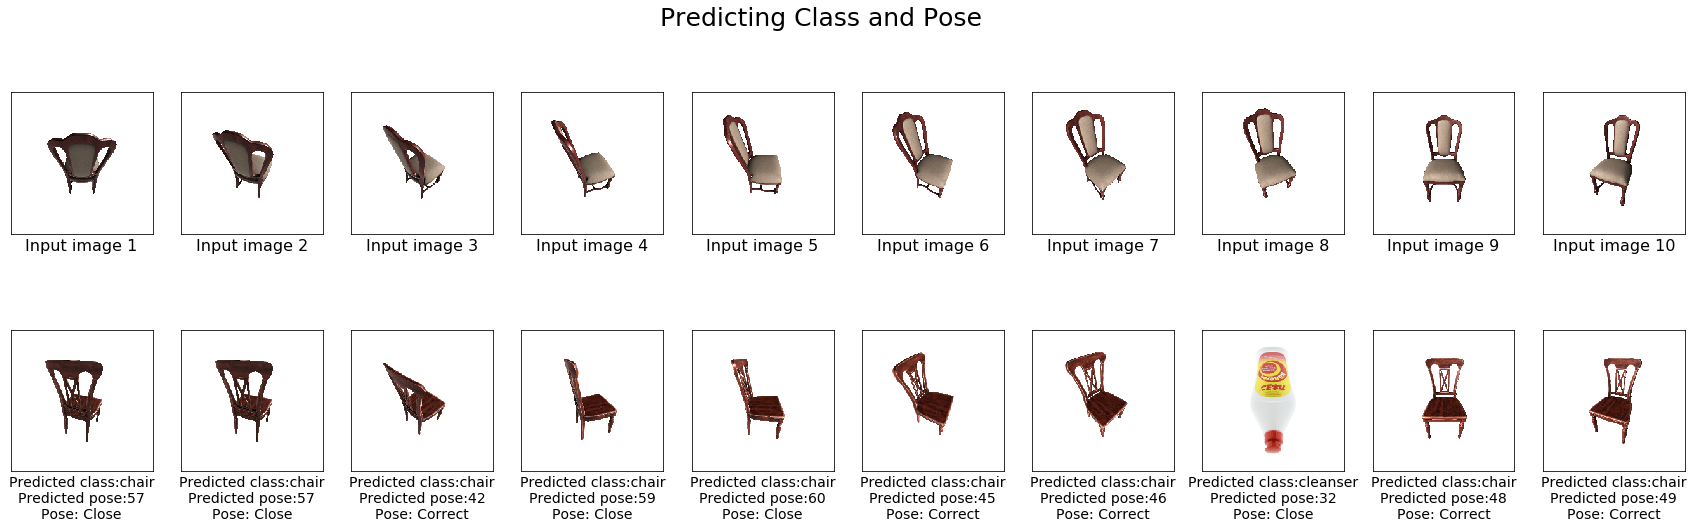

************************************************************
PREDICTED CLASS: chair -- predicted from 10 views
************************************************************


In [22]:
# Grab a randomly-sized group of views of a single object from validation set for inference
startGroup = 2
group = startGroup*nview
xb = torch.cuda.FloatTensor()
randnum = random.randint(1,20)
# samp = iter(random.sample(range(nview), randnum))
sampleRange = range(40,50)
samp = iter(sampleRange)

fig=plt.figure(figsize=(30, 8))
columns = 10 #columns = min(randnum, 10)
rows = 2
j = 1

for i in range(10): #put randnum in range() for random sampling
    imgIdx = next(samp)
#     print(data.valid_ds.x.items[group+imgIdx], imgIdx, i)
    img = open_image(data.valid_ds.x.items[group+imgIdx])
    batch = learn.data.one_item(img)
    b,_ = batch
    xb = torch.cat((xb, b), dim=0)
    
    if i<10:
        img = PIL.Image.open(data.valid_ds.x.items[group+imgIdx])
        fig.add_subplot(rows, columns, j)
        plt.xlabel('Input image '+str(i+1), fontsize=16)
        plt.tick_params(axis='both', left=False, bottom=False, labelbottom=False, labelleft=False)
        fig.suptitle('Predicting Class and Pose', fontsize=25)
        j += 1
        plt.imshow(img)
        
xb = [xb]
learn.model.eval()
out = learn.model(*xb)
batch_size = xb[0].size(0)
num_classes = int(out.size( 1 )/ nview) - 1
out = out.view( -1, num_classes + 1 )
out = torch.nn.functional.log_softmax( out, dim=1 )
out = out[ :, :-1 ] - torch.t( out[ :, -1 ].repeat(1, out.size(1)-1).view(out.size(1)-1, -1) )
predictions = []
posePreds = []
for i in range(batch_size): 
    maxVals, idxs = torch.max(out[i*nview:i*nview+nview], dim=1)
    predictions.append(idxs[torch.argmax(maxVals)].item())
    posePreds.append(torch.argmax(maxVals).item())
#     print('prediction:', classes[idxs[torch.argmax(maxVals)].item()], '-- pose:', torch.argmax(maxVals).item())
values, counts = np.unique(predictions, return_counts=True)


j = columns+1

for i in range(10):
    pose = vcand[viewOrd[predictions[i]]][posePreds[i]]
    img = PIL.Image.open(sorted_img[predictions[i]*nview*9+nview*2+pose])
    start = sampleRange[0]+i
    poseArr = np.array([start-1, start+1, start-15, start-16, start-17, start+15, start+16, start+17])
    if pose == start:
        cPose = 'Correct'
    elif pose in poseArr:
        cPose = 'Close'
    else:
        cPose = 'Incorrect'
    fig.add_subplot(rows, columns, j)
#     plt.ylabel('Predicted pose:'+str(posePreds[i]), fontsize=16)
    plt.xlabel('Predicted class:'+classes[predictions[i]]+'\nPredicted pose:'+str(pose)+'\nPose: '+cPose, fontsize=14)
    plt.tick_params(axis='both', left=False, bottom=False, labelbottom=False, labelleft=False)
    j += 1
    plt.imshow(img)
    if i == batch_size-1:
        break

plt.show()
# plt.tight_layout()

print('*'*60)
print('PREDICTED CLASS:', classes[values[np.argmax(counts)]], '-- predicted from', batch_size, 'views')
if batch_size > 10:
    print('Showing first 10 views only')
print('*'*60)


In [23]:
learn.export('export_rN_expanded.pkl')